In [105]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import os
import sys
import glob
from copy import deepcopy
import datetime
import platform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

In [2]:
if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "F:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "F:\\YandexDisk\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"    
    
elif 'Linux' in platform.platform() and '4.4.0' in platform.release():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"
    DELIMITER = "/"
    
else:
    print('unknown system', platform.platform(), platform.release())

TEST_PIC = _ + 'test_pic'
sys.path.append(PACK_DIR)
from PRAO import *

In [3]:
files_0531 = glob.glob(ALL_DATA + '0531+21' 
                      + DELIMITER + '*' +  DELIMITER + '*' + DELIMITER + 
                      '*_profiles.txt')
print('Main object: 0531+21; Numbers of files: ' + str(len(files_0531)))

Main object: 0531+21; Numbers of files: 2816


In [4]:
# установка диапазона дат
date_start = datetime.datetime(2018, 1, 1, 0, 0)
data_stop = datetime.datetime(2019, 11, 18, 0, 0)

In [5]:
main_set = [x for x in files_0531
             if date_start <= datetime.datetime.strptime(os.path.basename(x)[:6], '%d%m%y') <= data_stop]
print('Main set: 0531+21; Numbers of files: ' + str(len(main_set)))

Main set: 0531+21; Numbers of files: 292


In [30]:
gp_crab = pd.DataFrame(columns=[
    'Date', 
    'Time start', 
    'Tay, ms',
    'Period, s',
    'Numpointwin, point',
    'Numpulse, a.u.',
    'Median, adc u',
    'STD, adc u',
    'path obs plot',
    'path obs data',
    'Numbers of GP, u',
    'point of gp, point',
    'amp of gp, adc u',
    'W50, point',
    'W10, point',
    'path plot',
    
])

In [111]:
head, main_pulse, data_pulses, back = read_profiles_MD('new_data/281017_0531+21_00_profiles.txt')

In [112]:
non_cor_data = []
for pulse, backg in zip(data_pulses, back):
    non_cor_data.append(pulse + backg)

In [113]:
obser = np.hstack(non_cor_data)

In [114]:
diag = []
for x in tqdm_notebook(np.linspace(-1.2, 1.2, len(obser) + int(head['numpointwin']))):
    if x == 0:
        diag.append(1)
    else:
        diag.append((np.sin(x)/x)**2)

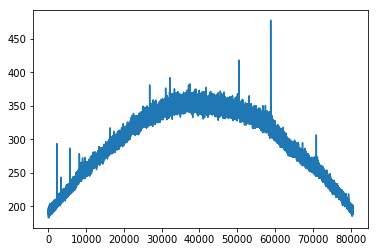

In [115]:
plt.close()
plt.plot(obser)
plt.show()

In [116]:
cor_d = []
for data_point, coeff in zip(obser, diag):
    cor_d.append(data_point/coeff)
cor_d = np.asarray(cor_d)

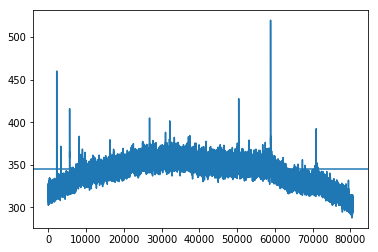

In [117]:
plt.close()
plt.plot(cor_d)
plt.axhline(np.median(cor_d))
plt.show()

In [118]:
med_flux = np.median(cor_d)
cor_d = cor_d.reshape(int(head['numpuls'])-1, int(head['numpointwin']))

In [119]:
final_array = []
for pulse in cor_d:
    l_edge = np.median(pulse[:6])
    r_edge = np.median(pulse[-5:])
    array_coef = np.linspace(l_edge, r_edge, len(pulse))
    coef_pulse = []
    for point, cf in zip(pulse, array_coef):
        coef_pulse.append(point-cf + med_flux)
    final_array.append(coef_pulse)
final_array = np.asarray(final_array)
flat_obser = np.hstack(final_array)

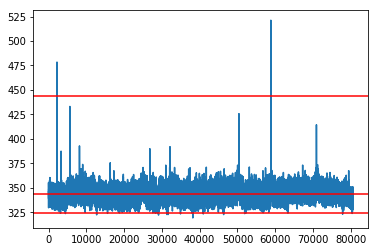

In [120]:
plt.close()
plt.plot(flat_obser) #[24150:24300]
plt.axhline(np.median(flat_obser), color='r')
plt.axhline(np.median(flat_obser) + 15*np.std(flat_obser), color='red')
plt.axhline(np.median(flat_obser) - 3*np.std(flat_obser), color='red')
#plt.axhline(np.min(flat_obser), color='green')
#plt.axhline(np.median(flat_obser_calib), color='r')
#plt.axhline(np.median(flat_obser_calib)*3, color='pink')
plt.savefig('crab_observ_' + head['date'] + '.png', format='png', dpi=100)
plt.show()

In [131]:
idx = np.argwhere(np.diff(np.sign(flat_obser - 15*np.std(flat_obser) - med_flux))).flatten()
gp_numbers = int(len(idx)/2)

In [132]:
gp_numbers

2

In [125]:
thres = np.median(flat_obser) + 15*np.std(flat_obser)
giant_pulses = [[]]
i = 0
for point in flat_obser:
    if point >= thres:
        giant_pulses[i].append(point)
    else:
        giant_pulses.append([])
        i +=1
giant_pulses = [i for i in giant_pulses if len(i)>0]

In [127]:
len(giant_pulses)

2

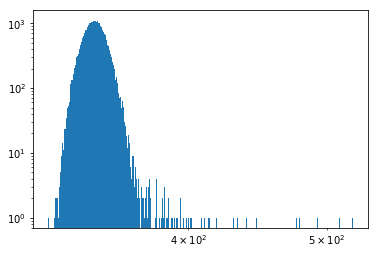

In [72]:
bins = np.linspace(np.min(flat_obser), np.max(flat_obser), 1000)
plt.close()
plt.hist(flat_obser, bins)
plt.loglog(True)
plt.show()

## Вытаскивание импульсов и определение их фп.

58851


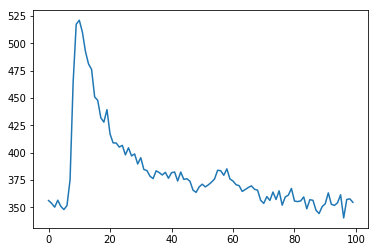

58851


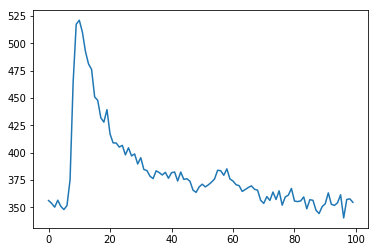

In [154]:
test_flat_obser = copy(flat_obser)
for i in range(len(giant_pulses)):
    x_max = np.argmax(test_flat_obser)
    print(x_max)
    pulse = test_flat_obser[x_max - 10: x_max + 90]
    plt.close()
    plt.plot(pulse)
    plt.show()
    medias = np.full(len(pulse), med_flux)
    test_flat_obser[x_max - 10: x_max + 90] = medias

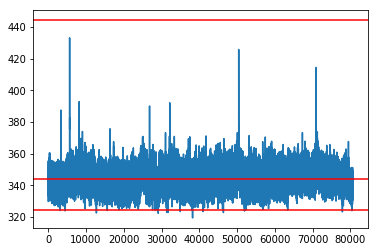

In [130]:
plt.close()
plt.plot(test_flat_obser) #[24150:24300]
plt.axhline(np.median(flat_obser), color='r')
plt.axhline(np.median(flat_obser) + 15*np.std(flat_obser), color='red')
plt.axhline(np.median(flat_obser) - 3*np.std(flat_obser), color='red')
#plt.axhline(np.min(flat_obser), color='green')
#plt.axhline(np.median(flat_obser_calib), color='r')
#plt.axhline(np.median(flat_obser_calib)*3, color='pink')
#plt.savefig('crab_observ_' + head['date'] + '.png', format='png', dpi=100)
plt.show()

In [133]:
len(test_flat_obser)

80586

In [134]:
len(flat_obser)

80586

In [161]:
width_of_pulse(pulse - med_flux, 0.5)

(9.207, 7.6725, 16.8795)

## Запуск полной обработки на всем массиве файлов

In [18]:
for file_name in tqdm_notebook(main_set):
    head, main_pulse, data_pulses, back = read_profiles_MD(file_name)
    
    non_cor_data = []
    for pulse, backg in zip(data_pulses, back):
        non_cor_data.append(pulse + backg)
    obser = np.hstack(non_cor_data)
    
    diag = []
    for x in np.linspace(-1.2, 1.2, len(obser) + int(head['numpointwin'])):
        if x == 0:
            diag.append(1)
        else:
            diag.append((np.sin(x)/x)**2)
            
    cor_d = []
    for data_point, coeff in zip(obser, diag):
        cor_d.append(data_point/coeff)
    cor_d = np.asarray(cor_d)
            
    med_flux = np.median(cor_d)
    cor_d = cor_d.reshape(int(head['numpuls'])-1, int(head['numpointwin']))   
    
    final_array = []
    for pulse in cor_d:
        l_edge = np.median(pulse[:6])
        r_edge = np.median(pulse[-5:])
        array_coef = np.linspace(l_edge, r_edge, len(pulse))
    
        coef_pulse = []
        for point, cf in zip(pulse, array_coef):
            coef_pulse.append(point-cf + med_flux)
        final_array.append(coef_pulse)
    final_array = np.asarray(final_array)
    flat_obser = np.hstack(final_array)
    #  writing session of observation
    fName =  './obs_data/' + head['date'] + '_obs_'+ head['name'] + '.csv'
    head_file = (
        'name ' + head['name'] + '\n' 
        + 'date ' + head['date'] + '\n' 
        + 'time ' + head['time'] + '\n' 
        + 'period ' + head['period'] + '\n' 
        + 'numpuls ' + head['numpuls'] + '\n'
        + 'tay ' + head['tay'] + '\n'
        + 'numpointwin ' + str(int(head["l_point_win"])+1) + '\n')  
    np.savetxt(
        fName, 
        flat_obser, 
        fmt='%1.5f', 
        delimiter='\t', 
        newline='\n', 
        header=head_file, 
        comments='')

'26.02.2018'

## Работа с файлами из директории ./obs_data

In [89]:
files_0531 = sorted(
    glob.glob('.\\obs_data\\*06.2011*'), 
    key=lambda x: datetime.datetime.strptime(os.path.basename(x), '%d.%m.%Y_obs_0531+21.csv'))
len(files_0531)

26

In [21]:
def read_head(filename, numpar):
    header = {}
    with open(filename, 'r') as file:
        for i in range(numpar):
            a, *b = file.readline().split()
            try:
                header[a] = b[0] + '.' + b[1]
            except IndexError:
                header[a] = b[0].replace(',', '.')
    return header

In [22]:
read_head(files_0531[0], 7)

{'date': '13.02.2010',
 'name': '0531+21',
 'numpointwin': '2430',
 'numpuls': '34',
 'period': '5.98834594172',
 'tay': '2.4576',
 'time': '20:26:28.9413394'}

In [23]:
flat_obs = np.genfromtxt(files_0531[0], skip_header=7)

In [24]:
flat_obs[0]

542.85286

In [25]:
files_0531[0]

'.\\obs_data\\13.02.2010_obs_0531+21.csv'

In [ ]:
idx = 0
for name in tqdm_notebook(files_0531):
    head = read_head(name, 7)
    flat_obs = np.genfromtxt(name, skip_header=7)
    med_flux = np.median(flat_obs)
    std_obs = np.std(flat_obs)
    
    cross_gp = np.argwhere(np.diff(np.sign(flat_obs - 15*std_obs - med_flux))).flatten()
    gp_numbers = int(len(cross_gp)/2)
    
    # ploting and writing session of observation
    fName_plot =  './obs_plot/' + head['date'] + '_plot_'+ head['name'] + '.png'
    plt.close()
    plt.title('Session of observation of Crab in ' + head['date'])
    plt.xlabel('Number of point, dt = ' + head['tay']  + ' ' + 'ms')
    plt.ylabel('Flux density, ADC units')
    plt.plot(flat_obs) #[24150:24300]
    plt.axhline(np.median(flat_obs), color='r')
    plt.axhline(np.median(flat_obs) + 15*std_obs, color='red')
    plt.axhline(np.median(flat_obs) - 3*std_obs, color='red')
    plt.savefig(fName_plot, format='png', dpi=100)
    
    fName_hist =  './hist_plot/' + head['date'] + '_hist_'+ head['name'] + '.png'
    bins = np.linspace(np.min(flat_obs), np.max(flat_obs), 1000)
    plt.close()
    plt.title('Distribution of pulses of Crab observation in ' + head['date'])
    plt.xlabel('Flux density, ADC units')
    plt.ylabel('Number of pulses')
    plt.hist(flat_obs, bins)
    plt.savefig(fName_hist, format='png', dpi=100)
    
    
    
    if gp_numbers != 0:
        test_flat_obser = copy(flat_obs)
        for i in range(gp_numbers):
            x_max = np.argmax(test_flat_obser)
            pulse = test_flat_obser[x_max - 10: x_max + 90]
            path_pulse = './gp_plot/' + head['date'] + '_plot_'+ head['name'] + '_'+ str(i)  + '.png'
            plt.close()
            plt.title('Session of observation of Crab in ' + head['date'])
            plt.xlabel('Number of point, dt = ' + head['tay']  + ' ' + 'ms')
            plt.ylabel('Flux density, ADC units')
            plt.plot(pulse)
            plt.savefig(path_pulse, format='png', dpi=100)
            w10, _, _ =  width_of_pulse(pulse, 0.1)
            w50, _, _ = width_of_pulse(pulse, 0.5)
            amp = max(pulse)
            medias = np.full(len(pulse), med_flux)
            test_flat_obser[x_max - 10: x_max + 90] = medias
        
            gp_crab.loc[idx] = [
                head['date'],
                head['time'],
                head['tay'],
                head['period'],
                head['numpointwin'],
                head['numpuls'],
                med_flux,
                std_obs,
                fName_plot,
                name,
                gp_numbers,
                x_max,
                amp,
                w50,
                w10,
                path_pulse
            ]
            idx += 1
    else:
        continue
    
    

In [25]:
gp_crab

,Date,Time start,"Tay, ms","Period, s","Numpointwin, point","Numpulse, a.u.","Median, adc u","STD, adc u",path obs plot,path obs data,"Numbers of GP, u","point of gp, point","amp pf gp, adc u","W50, point","W10, point",path plot
0,27.12.2016,23:34:25.3606491,2.4576,6.00416829791,2439,34,137.371130,2.416950,./obs_plot/27.12.2016_plot_0531+21.png,.\obs_data\27.12.2016_obs_0531+21.csv,1,53256,175.67461,99.00000,99.0,./gp_plot/27.12.2016_plot_0531+21_0.png
1,02.03.2017,19:18:52.1342391,2.4576,6.00503719641,2440,34,102.680185,1.648675,./obs_plot/02.03.2017_plot_0531+21.png,.\obs_data\02.03.2017_obs_0531+21.csv,1,65462,128.12125,99.00000,99.0,./gp_plot/02.03.2017_plot_0531+21_0.png
2,29.05.2017,13:32:52.9827804,2.4576,6.00518547389,2440,34,123.299005,22.476281,./obs_plot/29.05.2017_plot_0531+21.png,.\obs_data\29.05.2017_obs_0531+21.csv,13,68653,482.41981,99.00000,99.0,./gp_plot/29.05.2017_plot_0531+21_0.png
3,29.05.2017,13:32:52.9827804,2.4576,6.00518547389,2440,34,123.299005,22.476281,./obs_plot/29.05.2017_plot_0531+21.png,.\obs_data\29.05.2017_obs_0531+21.csv,13,68638,474.22202,14.60745,99.0,./gp_plot/29.05.2017_plot_0531+21_1.png
4,29.05.2017,13:32:52.9827804,2.4576,6.00518547389,2440,34,123.299005,22.476281,./obs_plot/29.05.2017_plot_0531+21.png,.\obs_data\29.05.2017_obs_0531+21.csv,13,68626,463.40290,11.60280,99.0,./gp_plot/29.05.2017_plot_0531+21_2.png
5,29.05.2017,13:32:52.9827804,2.4576,6.00518547389,2440,34,123.299005,22.476281,./obs_plot/29.05.2017_plot_0531+21.png,.\obs_data\29.05.2017_obs_0531+21.csv,13,68591,460.51608,34.63020,99.0,./gp_plot/29.05.2017_plot_0531+21_3.png
6,29.05.2017,13:32:52.9827804,2.4576,6.00518547389,2440,34,123.299005,22.476281,./obs_plot/29.05.2017_plot_0531+21.png,.\obs_data\29.05.2017_obs_0531+21.csv,13,68535,458.20739,55.62810,99.0,./gp_plot/29.05.2017_plot_0531+21_4.png
7,29.05.2017,13:32:52.9827804,2.4576,6.00518547389,2440,34,123.299005,22.476281,./obs_plot/29.05.2017_plot_0531+21.png,.\obs_data\29.05.2017_obs_0531+21.csv,13,68524,449.58228,10.61775,99.0,./gp_plot/29.05.2017_plot_0531+21_5.png
8,29.05.2017,13:32:52.9827804,2.4576,6.00518547389,2440,34,123.299005,22.476281,./obs_plot/29.05.2017_plot_0531+21.png,.\obs_data\29.05.2017_obs_0531+21.csv,13,68512,448.39586,11.61765,99.0,./gp_plot/29.05.2017_plot_0531+21_6.png
9,29.05.2017,13:32:52.9827804,2.4576,6.00518547389,2440,34,123.299005,22.476281,./obs_plot/29.05.2017_plot_0531+21.png,.\obs_data\29.05.2017_obs_0531+21.csv,13,68501,406.41485,10.65240,99.0,./gp_plot/29.05.2017_plot_0531+21_7.png


In [26]:
gp_crab.to_csv('crab_gp_kaz.csv',  sep='\t', header=True, index=False)

### Усложнение таблицы + расчет от 10 сигм

In [16]:
import os
import sys
import glob
import copy
import datetime
import platform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

In [17]:
gp_crab = pd.DataFrame(columns=[
    'Date', 
    'Time start', 
    'Tay, ms',
    'Period, s',
    'Numpointwin, point',
    'Numpulse, a.u.',
    'Median, adc u',
    'STD, adc u',
    'path obs plot',
    'path obs data',
    'Count of GP, u',
    'point of gp, point',
    'amp of gp, adc u',
    'W50, point',
    'W10, point',
    'path plot',
    
])

In [3]:
files_0531 = sorted(
    glob.glob('.\\obs_data\\*'), 
    key=lambda x: datetime.datetime.strptime(os.path.basename(x), '%d.%m.%Y_obs_0531+21.csv'))
len(files_0531)

2541

In [9]:
def read_head(filename, numpar):
    header = {}
    with open(filename, 'r') as file:
        for i in range(numpar):
            a, *b = file.readline().split()
            try:
                header[a] = b[0] + '.' + b[1]
            except IndexError:
                header[a] = b[0].replace(',', '.')
    return header

In [ ]:
idx = 0
for name in tqdm_notebook(files_0531):
    head = read_head(name, 7)
    flat_obs = np.genfromtxt(name, skip_header=7)
    med_flux = np.median(flat_obs)
    std_obs = np.std(flat_obs)
    
    fName_plot =  './obs_plot/' + head['date'] + '_plot_'+ head['name'] + '.png'
    plt.close()
    plt.plot(flat_obs) #[24150:24300]
    plt.axhline(med_flux, color='r')
    plt.axhline(med_flux + 10*std_obs, color='red')
    plt.axhline(med_flux - 3*std_obs, color='red')
    plt.savefig(fName_plot, format='png', dpi=100)
    
    fName_hist =  './hist_plot/' + head['date'] + '_hist_'+ head['name'] + '.png'
    bins = np.linspace(np.min(flat_obs), np.max(flat_obs), 1000)
    plt.close()
    plt.title('Distribution of pulses of Crab observation in ' + head['date'])
    plt.xlabel('Flux density, ADC units')
    plt.ylabel('Number of pulses')
    plt.hist(flat_obs, bins)
    plt.axvline(med_flux, color='r')
    plt.axvline(med_flux + 10*std_obs, color='red')
    plt.axvline(med_flux - 3*std_obs, color='red')
    plt.savefig(fName_hist, format='png', dpi=100)
    
    # ploting and writing session of observation
    test_flat_obser = deepcopy(flat_obs)
    
    i = 0
    
    while np.max(test_flat_obser) >= (10*std_obs + med_flux):
        x_max = np.argmax(test_flat_obser)
        pulse = test_flat_obser[x_max - 10: x_max + 90]
        
        path_pulse = './gp_plot/' + head['date'] + '_plot_'+ head['name'] + '_'+ str(i)  + '.png'
        plt.close()
        plt.title('Session of observation of Crab in ' + head['date'] + ' ' + '№' + str(i))
        plt.xlabel('Number of point, dt = ' + head['tay']  + ' ' + 'ms')
        plt.ylabel('Flux density, ADC units')
        plt.plot(pulse)
        plt.savefig(path_pulse, format='png', dpi=100)
        
        i += 1
        
        w10, _, _ =  width_of_pulse(pulse, 0.1)
        w50, _, _ = width_of_pulse(pulse, 0.5)
        amp = max(pulse)
        medias = np.full(len(pulse), med_flux)
        test_flat_obser[x_max - 10: x_max + 90] = medias
        
        gp_crab.loc[idx] = [
            head['date'],
            head['time'],
            head['tay'],
            head['period'],
            head['numpointwin'],
            head['numpuls'],
            med_flux,
            std_obs,
            fName_plot,
            name,
            1,
            x_max,
            amp,
            w50,
            w10,
            path_pulse
        ]
        
        idx += 1


In [21]:
np.argmax(test_flat_obser)

55772

[]

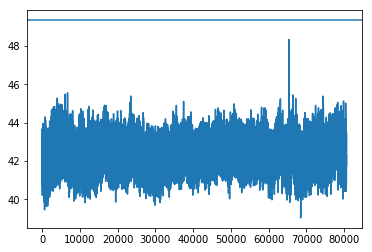

In [22]:
plt.close()
plt.plot(flat_obs)
plt.axhline(10*np.std(flat_obs) + np.median(flat_obs))
plt.plot()

In [40]:
np.std(flat_obs)

3.8422676022261903

In [23]:
print(len(gp_crab))
gp_crab.head(-10)

768


,Date,Time start,"Tay, ms","Period, s","Numpointwin, point","Numpulse, a.u.","Median, adc u","STD, adc u",path obs plot,path obs data,"Count of GP, u","point of gp, point","amp of gp, adc u","W50, point","W10, point",path plot
0,15.01.2016,22:22:38.4654350,2.4576,6.00210204423,2439,34,719.502190,11.528548,./obs_plot/15.01.2016_plot_0531+21.png,.\obs_data\15.01.2016_obs_0531+21.csv,1,61785,924.25417,99.0,99.0,./gp_plot/15.01.2016_plot_0531+21_0.png
1,28.01.2016,21:31:31.7480869,2.4576,6.00229427103,2439,34,538.250440,8.978479,./obs_plot/28.01.2016_plot_0531+21.png,.\obs_data\28.01.2016_obs_0531+21.csv,1,27919,705.48172,99.0,99.0,./gp_plot/28.01.2016_plot_0531+21_0.png
2,02.02.2016,21:11:52.2432174,2.4576,6.0023629396,2439,34,801.447740,12.969247,./obs_plot/02.02.2016_plot_0531+21.png,.\obs_data\02.02.2016_obs_0531+21.csv,1,5057,1041.97474,99.0,99.0,./gp_plot/02.02.2016_plot_0531+21_0.png
3,04.02.2016,21:04:00.4663017,2.4576,6.00238947153,2439,34,770.987110,12.384724,./obs_plot/04.02.2016_plot_0531+21.png,.\obs_data\04.02.2016_obs_0531+21.csv,1,39723,912.55581,99.0,99.0,./gp_plot/04.02.2016_plot_0531+21_0.png
4,07.02.2016,20:52:12.7584114,2.4576,6.00242816479,2439,34,734.389580,11.736352,./obs_plot/07.02.2016_plot_0531+21.png,.\obs_data\07.02.2016_obs_0531+21.csv,1,39294,878.88936,99.0,99.0,./gp_plot/07.02.2016_plot_0531+21_0.png
5,10.02.2016,20:40:25.0676345,2.4576,6.00246540891,2439,34,530.659450,8.431679,./obs_plot/10.02.2016_plot_0531+21.png,.\obs_data\10.02.2016_obs_0531+21.csv,1,37770,642.85162,99.0,99.0,./gp_plot/10.02.2016_plot_0531+21_0.png
6,10.02.2016,20:40:25.0676345,2.4576,6.00246540891,2439,34,530.659450,8.431679,./obs_plot/10.02.2016_plot_0531+21.png,.\obs_data\10.02.2016_obs_0531+21.csv,1,44730,625.72359,99.0,99.0,./gp_plot/10.02.2016_plot_0531+21_1.png
7,13.02.2016,20:28:37.3627548,2.4576,6.00250110128,2439,34,737.515830,11.689590,./obs_plot/13.02.2016_plot_0531+21.png,.\obs_data\13.02.2016_obs_0531+21.csv,1,8564,971.96368,99.0,99.0,./gp_plot/13.02.2016_plot_0531+21_0.png
8,18.02.2016,20:08:57.8583717,2.4576,6.00255715453,2439,34,759.471920,12.946473,./obs_plot/18.02.2016_plot_0531+21.png,.\obs_data\18.02.2016_obs_0531+21.csv,1,42454,1138.63782,99.0,99.0,./gp_plot/18.02.2016_plot_0531+21_0.png
9,18.02.2016,20:08:57.8583717,2.4576,6.00255715453,2439,34,759.471920,12.946473,./obs_plot/18.02.2016_plot_0531+21.png,.\obs_data\18.02.2016_obs_0531+21.csv,1,35427,897.41052,99.0,99.0,./gp_plot/18.02.2016_plot_0531+21_1.png


In [24]:
gp_crab.to_csv('crab_gp_kaz_10_2016-2018.csv',  sep='\t', header=True, index=False)

### Создание шаблона для ГИ 

In [6]:
files_0531 = sorted(
    glob.glob('.\\obs_data\\*2018*.csv'), 
    key=lambda x: datetime.datetime.strptime(os.path.basename(x), '%d.%m.%Y_obs_0531+21.csv'))
len(files_0531)

289

In [90]:
good_pulses = []
idx = 0
for name in files_0531:
    head = read_head(name, 7)
    if head['tay'] == '0.8192':
        
        flat_obs = np.genfromtxt(name, skip_header=7)

        med_flux_no_calib = np.median(flat_obs)
        test_flat_obser = deepcopy(flat_obs)
        test_flat_obser = test_flat_obser - med_flux_no_calib
        test_flat_obser = test_flat_obser + 1720
        std_obs = np.std(test_flat_obser)
        med_flux = np.median(test_flat_obser)

        while np.max(test_flat_obser) >= 1900:
            x_max = np.argmax(test_flat_obser)
            pulse = test_flat_obser[x_max - 10: x_max + 90] - med_flux
            good_pulses.append(pulse)
            medias = np.full(len(pulse), med_flux)
            test_flat_obser[x_max - 10: x_max + 90] = medias
    else:
        continue

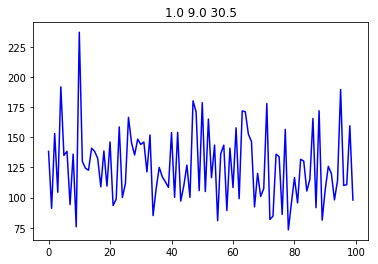

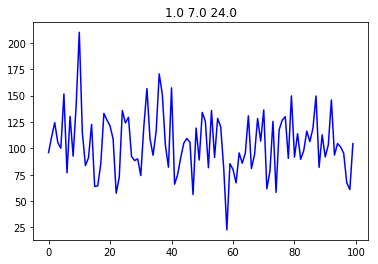

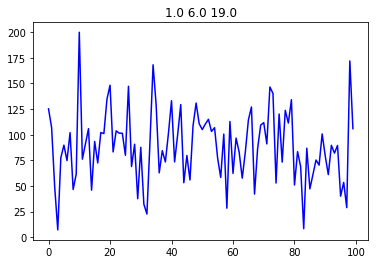

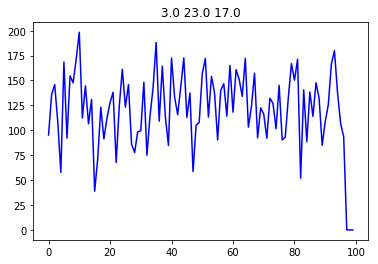

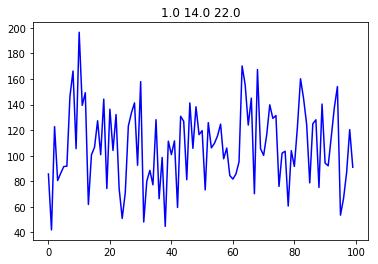

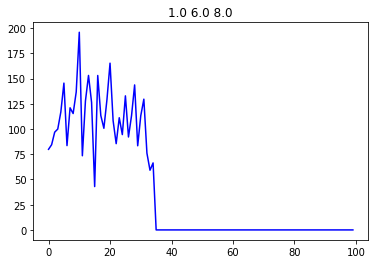

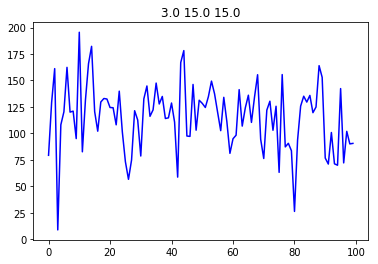

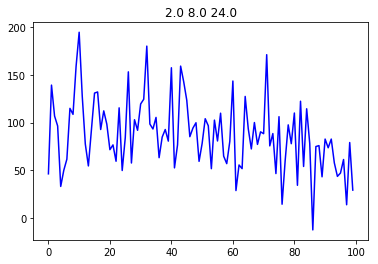

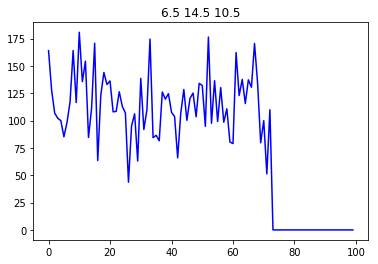

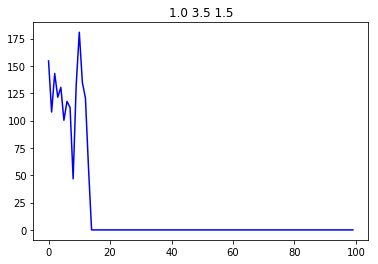

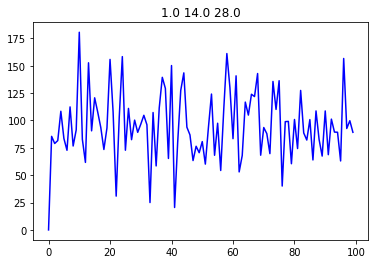

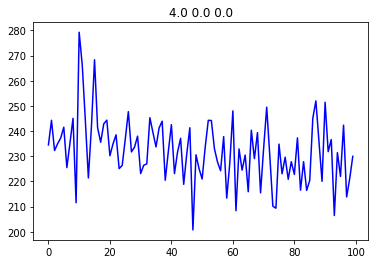

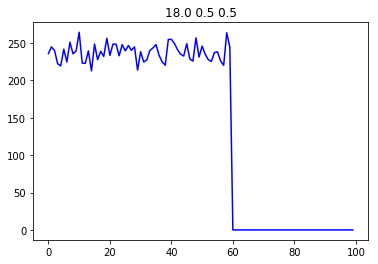

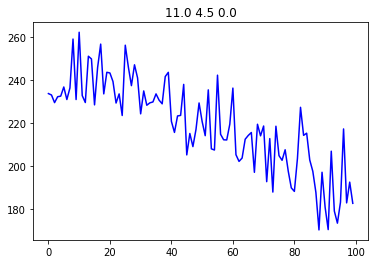

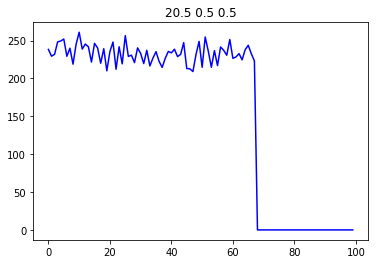

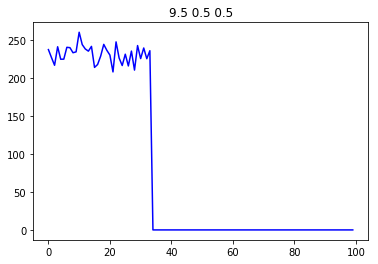

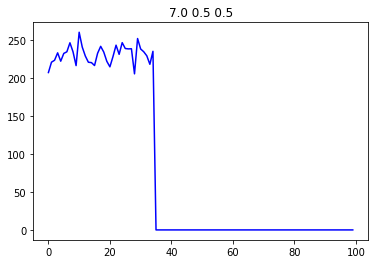

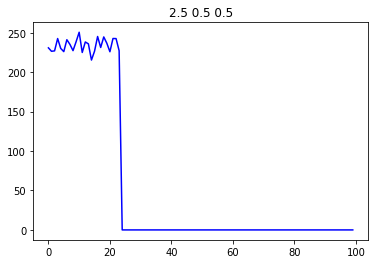

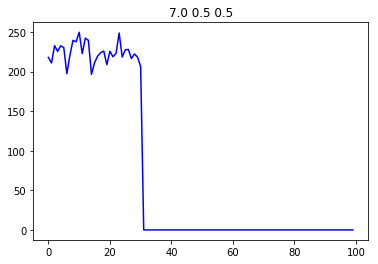

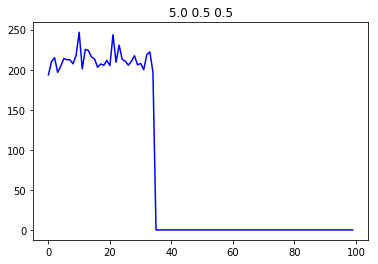

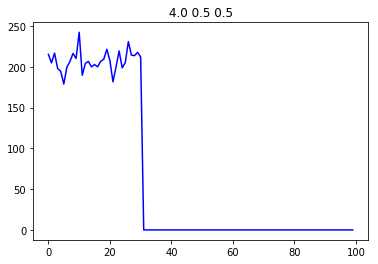

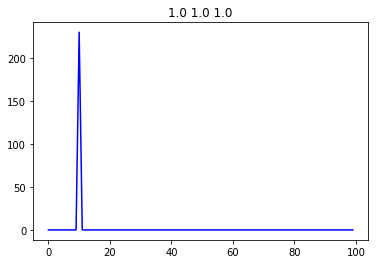

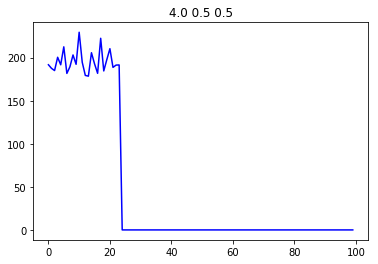

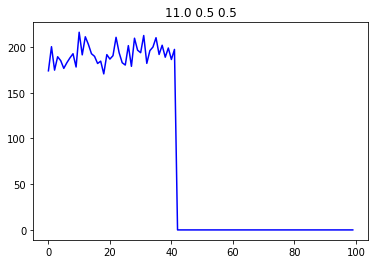

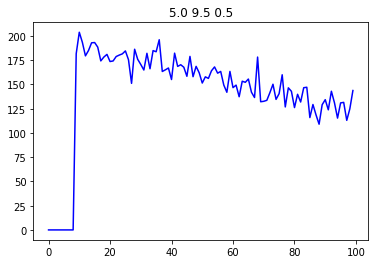

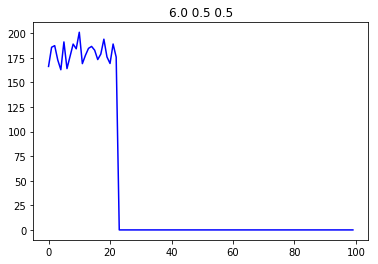

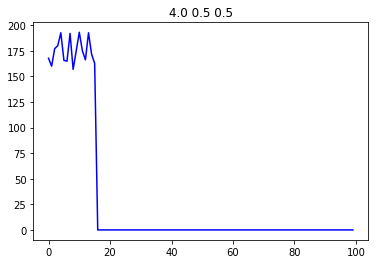

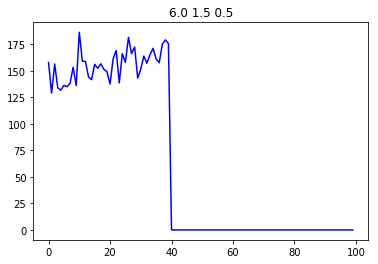

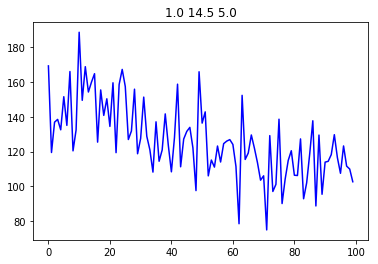

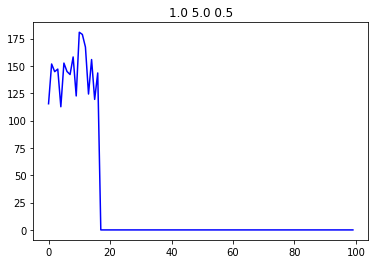

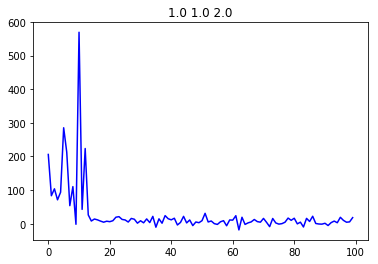

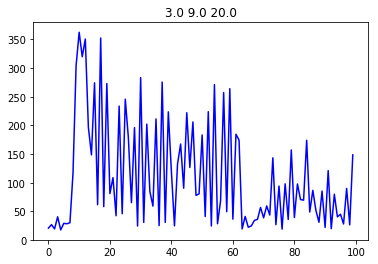

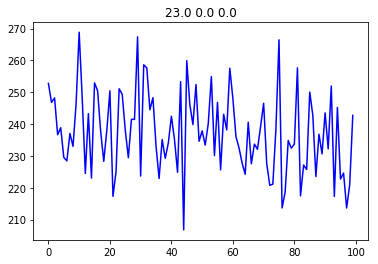

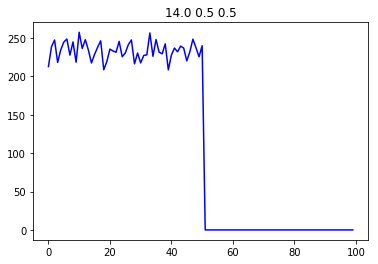

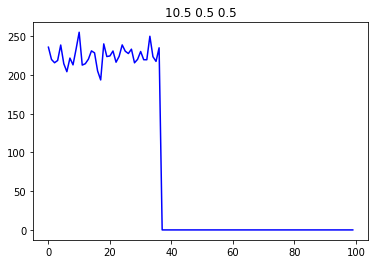

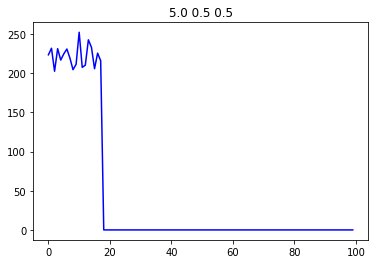

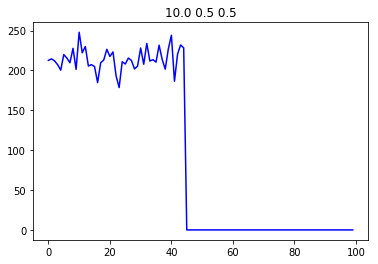

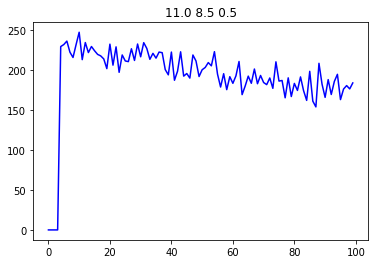

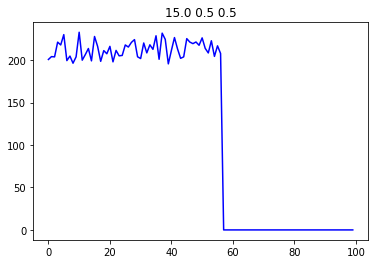

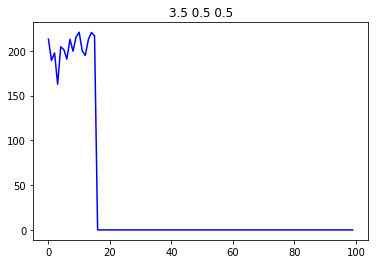

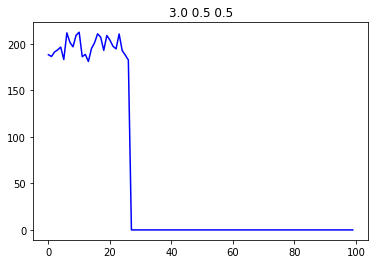

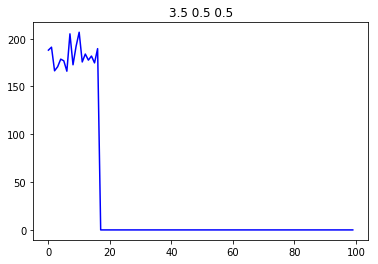

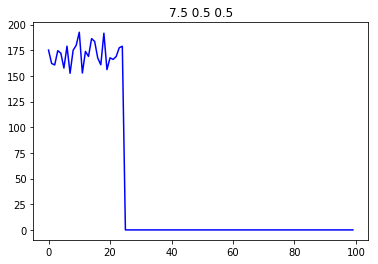

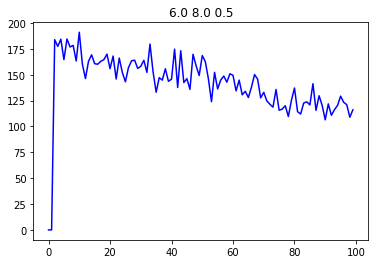

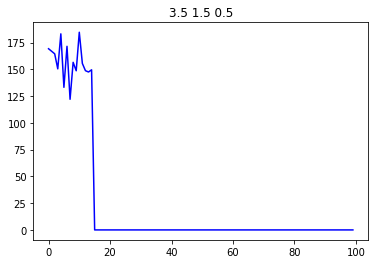

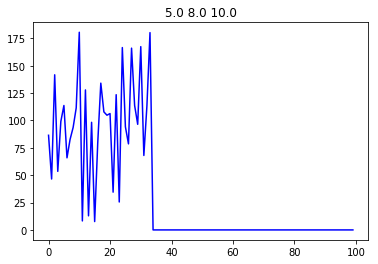

In [93]:
for pulse in good_pulses:
    intersection_09 = np.argwhere(np.diff(np.sign(pulse - 0.9*np.max(pulse)))).flatten()
    intersection_07 = np.argwhere(np.diff(np.sign(pulse - 0.7*np.max(pulse)))).flatten()
    intersection_05 = np.argwhere(np.diff(np.sign(pulse - 0.5*np.max(pulse)))).flatten()
    pulses_09 = str(len(intersection_09)/2)
    pulses_07 = str(len(intersection_07)/2)
    pulses_05 = str(len(intersection_05)/2)
    plt.close()
    plt.title(pulses_09 + ' ' + pulses_07 + ' ' + pulses_05)
    plt.plot(pulse, color='b')
    plt.show()
# print(len(good_pulses))

In [45]:
fName = 'GP_' + head['name'] + '_' + head['tay'] + '.csv'
head_file = 'name ' + head['name'] + '\n' + \
    'numpuls ' + str(1) + '\n' + \
    'tay ' + head['tay'] + '\n' + \
    'flux\n\n' # Добавление подписей колонок
        
np.savetxt(fName, good_pulses[0]/max(good_pulses[0]), fmt='%1.3f', newline='\n', header=head_file, comments='')

In [46]:
test_rear = np.loadtxt(fName, skiprows=4) 

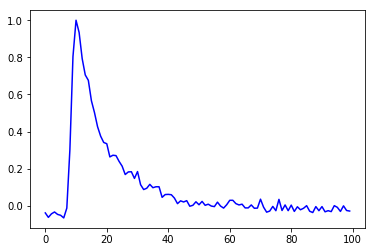

In [47]:
plt.close()
plt.plot(test_rear, color='b')
plt.show()

In [3]:
fName_test = './gp_plot_txt/' + '05.09.2010_plot_0531+21_1'  + '.csv'
test_rear = np.loadtxt(fName_test, skiprows=4) 

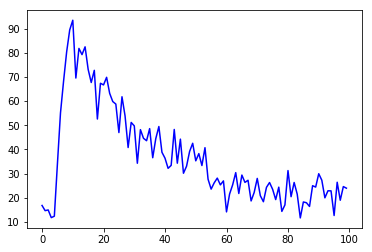

In [4]:
plt.close()
plt.plot(test_rear, color='b')
plt.show()